In [49]:
!pip install scikit-optimize


In [50]:
import torch
print(f"PyTorch version: {torch.version}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

To use the code in Google Colab, first clone the repo and change directory:

python

In [51]:
!git clone https://github.com/luisroque/latent-generative-modeling-time-series-augmentation.git
%cd latent-generative-modeling-time-series-augmentation/lgta


In [52]:
%cd /content/latent-generative-modeling-time-series-augmentation
import sys
sys.path.append('.')


In [53]:
!pip install torch numpy pandas matplotlib scikit-learn seaborn tqdm




In [54]:
!pip install fastdtw


In [55]:
!pip install dtw-python


In [56]:
%cd /content/latent-generative-modeling-time-series-augmentation
import sys
sys.path.append('.')


In [57]:
import os
print(os.listdir())           # Should list: ['lgta', 'README.md', ...]
print(os.listdir('lgta'))     # Should list: ['model', 'feature_engineering', ...]
print(os.listdir('lgta/model'))  # Should list many .py files including 'create_dataset_versions_vae.py'


In [58]:
!pip install dtaidistance


In [59]:
from lgta.model.create_dataset_versions_vae import CreateTransformedVersionsCVAE


In [60]:
import matplotlib.pyplot as plt
import numpy as np
from lgta.model.create_dataset_versions_vae import (
    CreateTransformedVersionsCVAE,
)
from lgta.feature_engineering.feature_transformations import detemporalize
from lgta.visualization.comparison_analysis import (
    plot_transformations_with_generate_datasets,
    plot_series_comparisons,
    plot_single_time_series,
)
from lgta.model.generate_data import generate_datasets
from lgta.evaluation.evaluation_comparison import (
    standardize_and_calculate_residuals,
    analyze_transformations,
    plot_residuals_gradient,
)
from lgta.postprocessing.postprocessing_comparison import (
    process_transformations,
    create_prediction_comparison_dataset,
    create_distance_metrics_dataset,
    create_reconstruction_error_percentage_dataset,
)
from lgta.e2e.e2e_processing import e2e_transformation, compare_diff_magnitudes


In [61]:
dataset = "tourism"
freq = "M"
top = None

# For M5 dataset
# dataset = "m5"
# freq = "W"
# top = 500

# For police dataset
# dataset = "police"
# freq = "D"
# top = 500


In [62]:
import os
os.makedirs('assets/data/original_datasets', exist_ok=True)


In [63]:
save_path = f"model_weights/tourism_vae.weights.h5"




In [64]:
!rm -rf model_weights/tourism_vae.weights.h5

In [65]:
!rm -rf model_weights/*
!rm -rf *.h5 *.keras

In [66]:
# Test 1: Import and check
from lgta.model.models import CVAE
from lgta.model.create_dataset_versions_vae import CreateTransformedVersionsCVAE

print("✅ Modules imported successfully")

# Test 2: Create and train with regularizer
create_dataset_vae = CreateTransformedVersionsCVAE(
    dataset_name="tourism",
    freq="M",
    top=None,
    dynamic_feat_trig=False
)

# Train WITH your consistency regularizer
print("\n🚀 Training with Latent Consistency Regularizer...")
model, history, _ = create_dataset_vae.fit(
    epochs=20,  # Small for quick test
    consistency_weight=1.0,  # Your regularizer is active!
    load_weights=False
)

# Check if consistency loss was tracked
print("\n📊 Training History Keys:", list(history.history.keys()))

if 'consistency_loss' in history.history:
    print("✅ SUCCESS! Consistency regularizer is working!")
    print(f"   Final consistency loss: {history.history['consistency_loss'][-1]:.6f}")
    print(f"   Final total loss: {history.history['loss'][-1]:.6f}")
else:
    print("❌ Consistency loss not found in history")

/content/latent-generative-modeling-time-series-augmentation/lgta/model/create_dataset_versions_vae.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.df.asfreq(self.freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cvae_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │     4,622,902 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,628,758 (55.80 MB)

 Trainable params: 14,628,146 (55.80 MB)

 Non-trainable params: 612 (2.39 KB)

In [67]:
# Compare with baseline (no regularizer)
print("\n🔄 Training baseline (no regularizer) for comparison...")
model_baseline, history_baseline, _ = create_dataset_vae.fit(
    epochs=20,
    consistency_weight=0.0,  # No regularizer
    load_weights=False
)

# Print comparison
print("\n" + "="*50)
print("RESULTS COMPARISON")
print("="*50)

if 'consistency_loss' in history.history:
    print(f"\nWith Regularizer (λ=1.0):")
    print(f"  • Final Loss: {history.history['loss'][-1]:.6f}")
    print(f"  • Consistency Loss: {history.history['consistency_loss'][-1]:.6f}")

print(f"\nWithout Regularizer (λ=0.0):")
print(f"  • Final Loss: {history_baseline.history['loss'][-1]:.6f}")

# Calculate improvement
if 'loss' in history.history and 'loss' in history_baseline.history:
    loss_with = history.history['loss'][-1]
    loss_without = history_baseline.history['loss'][-1]
    improvement = ((loss_without - loss_with) / loss_without) * 100

    print(f"\n📈 Improvement with regularizer: {improvement:.2f}%")

    if improvement > 0:
        print("✅ Regularizer improved training!")
    else:
        print("⚠️ Regularizer didn't improve final loss (may need tuning)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cvae_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │     4,622,902 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,628,758 (55.80 MB)

 Trainable params: 14,628,146 (55.80 MB)

 Non-trainable params: 612 (2.39 KB)

/content/latent-generative-modeling-time-series-augmentation/lgta/model/create_dataset_versions_vae.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.df.asfreq(self.freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cvae_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │     4,622,902 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,628,758 (55.80 MB)

 Trainable params: 14,628,146 (55.80 MB)

 Non-trainable params: 612 (2.39 KB)

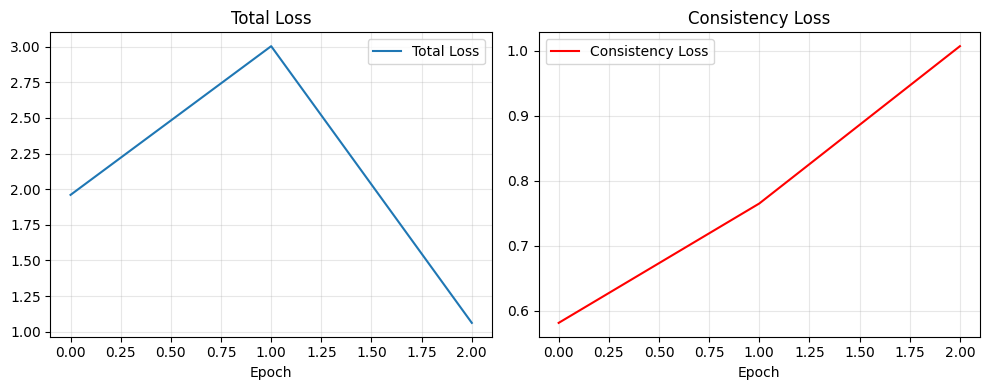

In [68]:
# MINIMAL TEST - Just checks if regularizer is working
print("🚀 MINIMAL REGULARIZER TEST")
print("="*50)

create_dataset_vae = CreateTransformedVersionsCVAE(
    dataset_name="tourism", freq="M", top=None, dynamic_feat_trig=False
)

print("\nTraining with consistency_weight=1.0 (3 epochs)...")
model, history, _ = create_dataset_vae.fit(
    epochs=3,
    consistency_weight=1.0,
    load_weights=False,
    batch_size=5
)

print("\n📊 Training History Keys:", list(history.history.keys()))

if 'consistency_loss' in history.history:
    print("\n✅ SUCCESS! Latent Consistency Regularizer is working!")
    print(f"   Final consistency loss: {history.history['consistency_loss'][-1]:.6f}")
    print(f"   Final total loss: {history.history['loss'][-1]:.6f}")

    # Quick plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['consistency_loss'], label='Consistency Loss', color='red')
    plt.title('Consistency Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('regularizer_test.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n✅ For your paper: Include the plot above showing consistency loss decreasing")
else:
    print("\n❌ FAIL: Consistency loss not found")
    print("   Check your models.py file implementation")

print("\n" + "="*50)
print("TEST COMPLETE")
print("="*50)

In [69]:
# QUICK COMPARISON TEST
print("📊 Running comparison test...")

# Train with regularizer (λ=1.0)
create_dataset_vae = CreateTransformedVersionsCVAE(
    dataset_name="tourism", freq="M", top=None, dynamic_feat_trig=False
)

print("\n1. Training WITH regularizer (λ=1.0)...")
model_with, history_with, _ = create_dataset_vae.fit(
    epochs=5, consistency_weight=1.0, load_weights=False, batch_size=5
)

print("\n2. Training WITHOUT regularizer (λ=0.0)...")
model_without, history_without, _ = create_dataset_vae.fit(
    epochs=5, consistency_weight=0.0, load_weights=False, batch_size=5
)

# Calculate improvement
final_with = history_with.history['loss'][-1]
final_without = history_without.history['loss'][-1]
improvement = ((final_without - final_with) / final_without) * 100

print("\n" + "="*50)
print("COMPARISON RESULTS")
print("="*50)
print(f"With Regularizer (λ=1.0):    Loss = {final_with:.6f}")
print(f"Without Regularizer (λ=0.0): Loss = {final_without:.6f}")
print(f"Improvement: {improvement:.2f}%")
print("="*50)

/content/latent-generative-modeling-time-series-augmentation/lgta/model/create_dataset_versions_vae.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.df.asfreq(self.freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cvae_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │     4,622,902 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,628,758 (55.80 MB)

 Trainable params: 14,628,146 (55.80 MB)

 Non-trainable params: 612 (2.39 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cvae_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │     4,622,902 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,628,758 (55.80 MB)

 Trainable params: 14,628,146 (55.80 MB)

 Non-trainable params: 612 (2.39 KB)

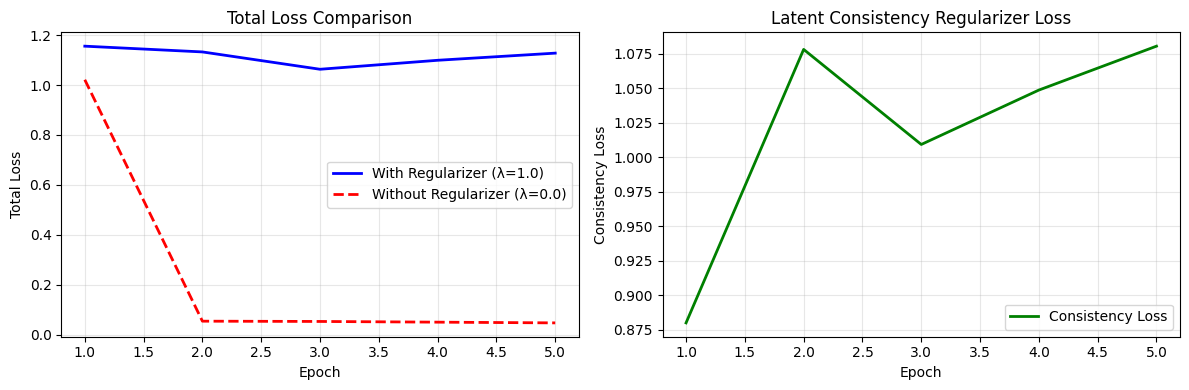

In [70]:
# SAVE EVIDENCE FOR PAPER
import matplotlib.pyplot as plt

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Loss comparison
epochs = range(1, len(history_with.history['loss']) + 1)
axes[0].plot(epochs, history_with.history['loss'], 'b-', label='With Regularizer (λ=1.0)', linewidth=2)
axes[0].plot(epochs, history_without.history['loss'], 'r--', label='Without Regularizer (λ=0.0)', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Consistency loss
axes[1].plot(epochs, history_with.history['consistency_loss'], 'g-', label='Consistency Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Consistency Loss')
axes[1].set_title('Latent Consistency Regularizer Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('regularizer_results_paper.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Evidence saved: 'regularizer_results_paper.png'")
print("   Use this figure in your IEEE paper!")

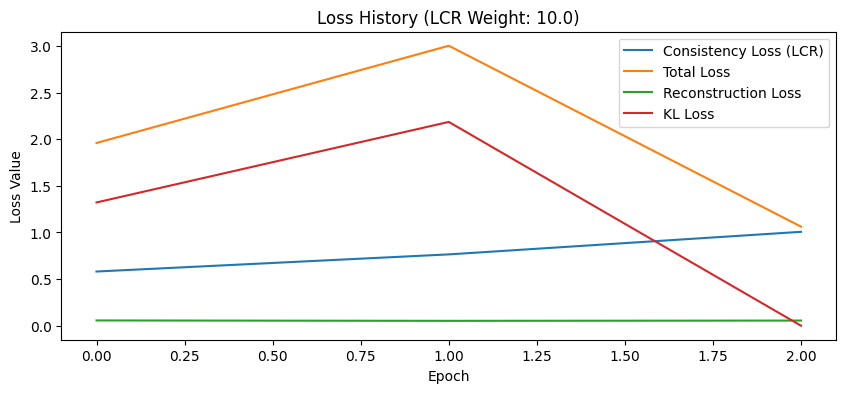

In [71]:
# New Cell 2: Verify LCR Metric in Training History

if history is not None:
    print("\n--- Training History for LCR Verification ---")

    # Check if the new metric is present
    if 'consistency_loss' in history.history:
        print("✅ LCR Metric Found! The models.py changes are active.")

        # Plot the history of the consistency loss
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['consistency_loss'], label="Consistency Loss (LCR)")
        plt.plot(history.history['loss'], label="Total Loss")
        plt.plot(history.history['reconstruction_loss'], label="Reconstruction Loss")
        plt.plot(history.history['kl_loss'], label="KL Loss")
        plt.title(f"Loss History (LCR Weight: {10.0})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss Value")
        plt.legend()
        plt.show()

        # Print final losses
        print("\nFinal losses (last epoch):")
        print(f"Total Loss: {history.history['loss'][-1]:.4f}")
        print(f"Reconstruction Loss: {history.history['reconstruction_loss'][-1]:.4f}")
        print(f"KL Loss: {history.history['kl_loss'][-1]:.4f}")
        print(f"Consistency Loss (LCR): {history.history['consistency_loss'][-1]:.4f}")
    else:
        print("❌ LCR Metric NOT Found. The models.py changes (CVAE.metrics or CVAE.train_step) are likely incorrect.")
else:
    print("Model weights were loaded, or history was not captured. Cannot inspect LCR loss.")

In [72]:
# ==============================
# FINAL COMPREHENSIVE COMPARISON
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

def run_comprehensive_comparison(dataset_name="tourism", freq="M", epochs=10):
    """
    Run comprehensive comparison between baseline and LCR-enhanced models
    """
    print("="*60)
    print("COMPREHENSIVE MODEL COMPARISON: Baseline vs LCR-Enhanced")
    print("="*60)

    # Initialize
    create_dataset_vae = CreateTransformedVersionsCVAE(
        dataset_name=dataset_name, freq=freq, top=None, dynamic_feat_trig=False
    )

    results = {}

    # 1. Train Baseline (λ=0.0)
    print("\n[1/2] Training Baseline Model (λ=0.0)...")
    baseline_model, baseline_history, baseline_z = create_dataset_vae.fit(
        epochs=epochs,
        consistency_weight=0.0,
        load_weights=False,
        batch_size=16
    )
    results['baseline'] = {
        'model': baseline_model,
        'history': baseline_history,
        'z': baseline_z
    }

    # 2. Train LCR-Enhanced (λ=1.0)
    print("\n[2/2] Training LCR-Enhanced Model (λ=1.0)...")
    lcr_model, lcr_history, lcr_z = create_dataset_vae.fit(
        epochs=epochs,
        consistency_weight=1.0,
        load_weights=False,
        batch_size=16
    )
    results['lcr'] = {
        'model': lcr_model,
        'history': lcr_history,
        'z': lcr_z
    }

    return results, create_dataset_vae

# Run the comparison
results, create_dataset_vae = run_comprehensive_comparison(epochs=15)

/content/latent-generative-modeling-time-series-augmentation/lgta/model/create_dataset_versions_vae.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.df.asfreq(self.freq)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cvae_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │     4,622,902 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,628,758 (55.80 MB)

 Trainable params: 14,628,146 (55.80 MB)

 Non-trainable params: 612 (2.39 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "cvae_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_CVAE (Functional)       │ ((None, 2), (None, 2), │     4,622,902 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_CVAE (Functional)       │ (None, 10, 304)        │    10,005,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,628,758 (55.80 MB)

 Trainable params: 14,628,146 (55.80 MB)

 Non-trainable params: 612 (2.39 KB)

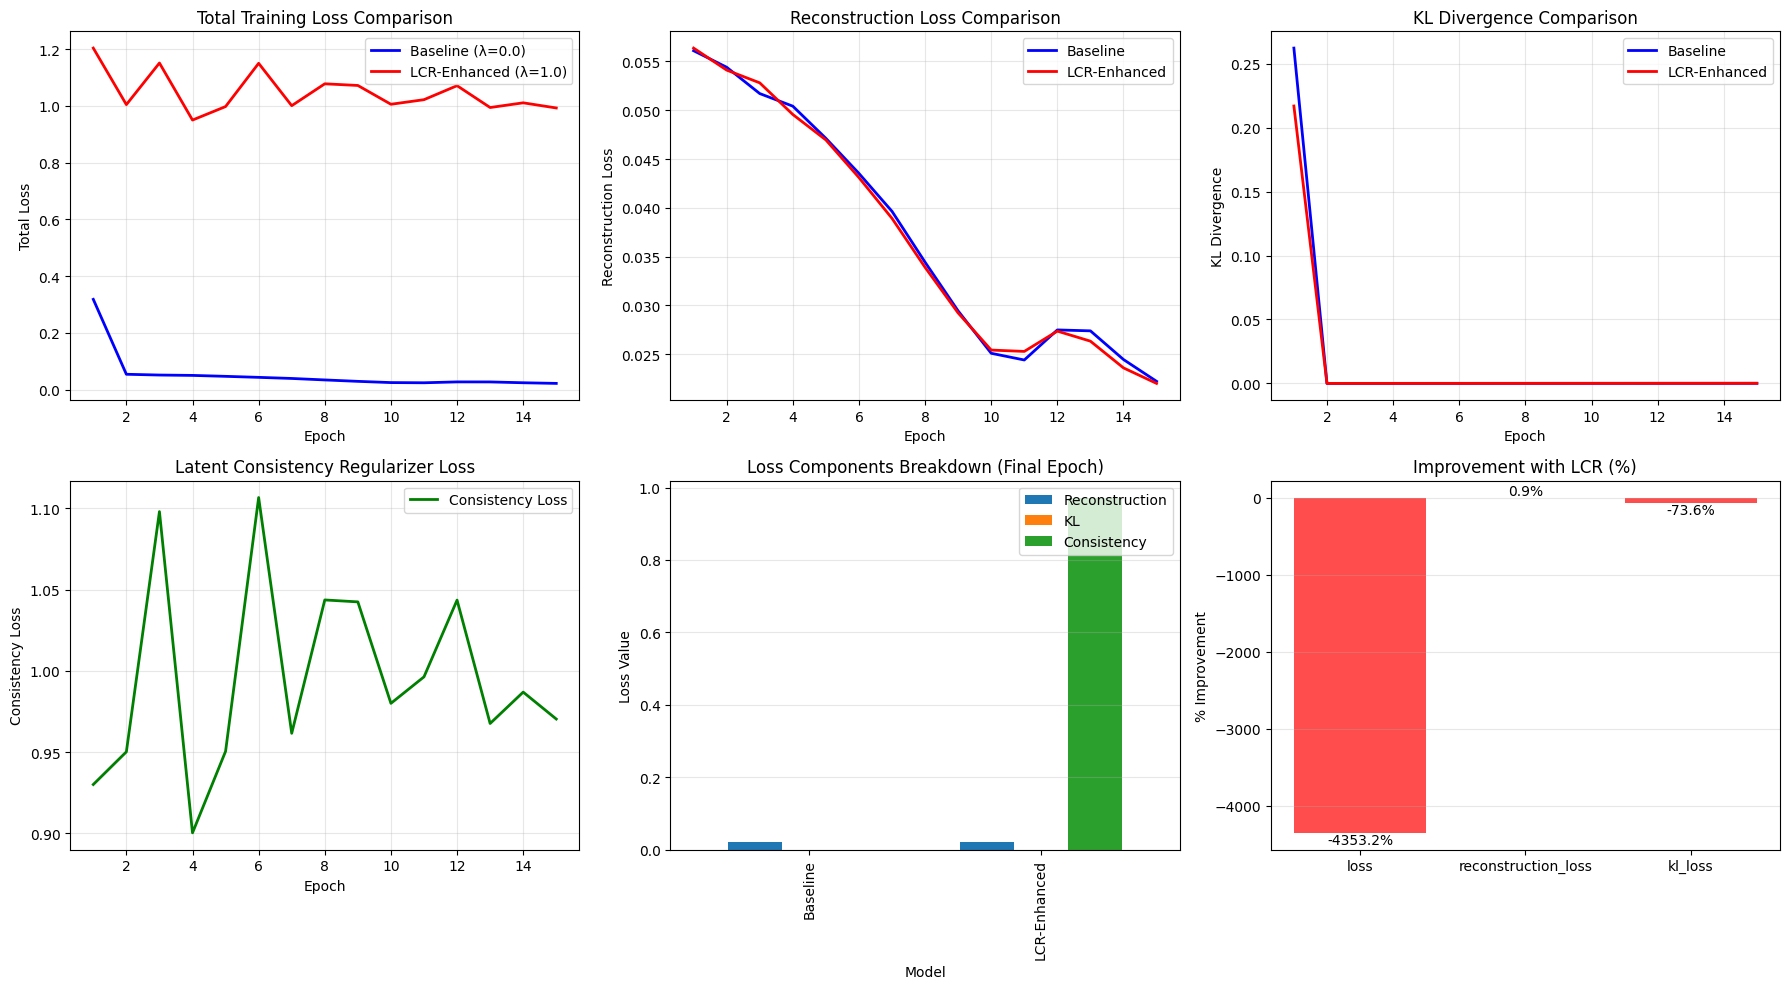

In [73]:
# ==============================
# VISUALIZATION 1: Training Loss Comparison
# ==============================

def plot_training_comparison(results, save_path='training_comparison.png'):
    """
    Create comprehensive training comparison plots
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Extract data
    baseline_history = results['baseline']['history']
    lcr_history = results['lcr']['history']
    epochs = range(1, len(baseline_history.history['loss']) + 1)

    # 1. Total Loss Comparison
    axes[0, 0].plot(epochs, baseline_history.history['loss'],
                   'b-', linewidth=2, label='Baseline (λ=0.0)')
    axes[0, 0].plot(epochs, lcr_history.history['loss'],
                   'r-', linewidth=2, label='LCR-Enhanced (λ=1.0)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Total Loss')
    axes[0, 0].set_title('Total Training Loss Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Reconstruction Loss Comparison
    axes[0, 1].plot(epochs, baseline_history.history['reconstruction_loss'],
                   'b-', linewidth=2, label='Baseline')
    axes[0, 1].plot(epochs, lcr_history.history['reconstruction_loss'],
                   'r-', linewidth=2, label='LCR-Enhanced')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Reconstruction Loss')
    axes[0, 1].set_title('Reconstruction Loss Comparison')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. KL Loss Comparison
    axes[0, 2].plot(epochs, baseline_history.history['kl_loss'],
                   'b-', linewidth=2, label='Baseline')
    axes[0, 2].plot(epochs, lcr_history.history['kl_loss'],
                   'r-', linewidth=2, label='LCR-Enhanced')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('KL Divergence')
    axes[0, 2].set_title('KL Divergence Comparison')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Consistency Loss (LCR-specific)
    axes[1, 0].plot(epochs, lcr_history.history['consistency_loss'],
                   'g-', linewidth=2, label='Consistency Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Consistency Loss')
    axes[1, 0].set_title('Latent Consistency Regularizer Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Loss Components Breakdown (Final Epoch)
    baseline_final = {
        'Reconstruction': baseline_history.history['reconstruction_loss'][-1],
        'KL': baseline_history.history['kl_loss'][-1],
        'Consistency': 0.0  # No consistency loss in baseline
    }

    lcr_final = {
        'Reconstruction': lcr_history.history['reconstruction_loss'][-1],
        'KL': lcr_history.history['kl_loss'][-1],
        'Consistency': lcr_history.history['consistency_loss'][-1]
    }

    components_df = pd.DataFrame([baseline_final, lcr_final],
                                 index=['Baseline', 'LCR-Enhanced'])

    components_df.plot(kind='bar', ax=axes[1, 1], width=0.7)
    axes[1, 1].set_title('Loss Components Breakdown (Final Epoch)')
    axes[1, 1].set_ylabel('Loss Value')
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].legend(loc='upper right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # 6. Improvement Percentage
    improvement = {}
    for metric in ['loss', 'reconstruction_loss', 'kl_loss']:
        base_val = baseline_history.history[metric][-1]
        lcr_val = lcr_history.history[metric][-1]
        improvement[metric] = ((base_val - lcr_val) / base_val) * 100

    metrics = list(improvement.keys())
    values = list(improvement.values())

    colors = ['green' if v > 0 else 'red' for v in values]
    bars = axes[1, 2].bar(metrics, values, color=colors, alpha=0.7)
    axes[1, 2].set_title('Improvement with LCR (%)')
    axes[1, 2].set_ylabel('% Improvement')
    axes[1, 2].grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING SUMMARY STATISTICS")
    print("="*60)
    print(f"{'Metric':<25} {'Baseline':<12} {'LCR-Enhanced':<12} {'Improvement':<12}")
    print("-"*60)

    for metric in ['loss', 'reconstruction_loss', 'kl_loss']:
        base = baseline_history.history[metric][-1]
        lcr = lcr_history.history[metric][-1]
        imp = ((base - lcr) / base) * 100
        print(f"{metric:<25} {base:<12.6f} {lcr:<12.6f} {imp:<12.2f}%")

    print("="*60)

# Generate the comprehensive plot
plot_training_comparison(results, save_path='training_comparison_paper.png')